<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Colab/Gold_Price_Forecasting_with_yfinance_FB_Prophet_and_ARIMA_Dec_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Price Forecasting with yfinance and Facebook Prophet

## Importing all the necessary Libraries

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 7.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [ ]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: GC=F
You entered GC=F, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
748,2021-12-10,1773.800049,1785.400024,1769.099976,1782.900024,545,0,0
749,2021-12-13,1784.400024,1787.099976,1783.800049,1786.300049,206,0,0
750,2021-12-14,1787.000000,1787.000000,1769.000000,1770.400024,322,0,0
751,2021-12-15,1767.400024,1778.699951,1753.900024,1762.599976,283,0,0
752,2021-12-16,1781.000000,1798.099976,1781.000000,1796.599976,21,0,0
753,2021-12-17,1804.000000,1812.900024,1803.800049,1803.800049,654,0,0
754,2021-12-20,1796.800049,1799.800049,1792.000000,1793.699951,226,0,0
755,2021-12-21,1791.400024,1796.500000,1787.900024,1787.900024,575,0,0
756,2021-12-22,1786.000000,1805.199951,1785.500000,1801.599976,575,0,0
757,2021-12-23,1805.599976,1811.400024,1799.000000,1806.800049,74592,0,0


In [ ]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,758.000000,758.000000,758.000000,758.000000,758.000000,758.0,758.0
mean,1651.269658,1659.680872,1642.704881,1651.299075,5433.885224,0.0,0.0
std,212.901388,215.140958,210.502153,212.855158,29610.250307,0.0,0.0
min,1260.300049,1268.500000,1260.300049,1267.500000,0.000000,0.0,0.0
25%,1481.625000,1487.250000,1473.850037,1479.149994,56.250000,0.0,0.0
50%,1729.049988,1739.550049,1720.900024,1728.850037,216.500000,0.0,0.0
75%,1812.375031,1820.175049,1804.950012,1812.299988,642.750000,0.0,0.0
max,2045.500000,2063.000000,2040.000000,2051.500000,346362.000000,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [ ]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [ ]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [ ]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [ ]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [ ]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 65, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet
__[Facebook Prophet Documentation](https://facebook.github.io/prophet/)__. 

In [ ]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
753,2021-12-17,1803.800049
754,2021-12-20,1793.699951
755,2021-12-21,1787.900024
756,2021-12-22,1801.599976
757,2021-12-23,1806.800049


##Facebook Prophet Model

In [ ]:
m=Prophet(yearly_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Forecasting

In [ ]:
periods = 30
future=m.make_future_dataframe(periods)

In [ ]:
forecast=m.predict(future)

In [ ]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-12-24,1250.757050,1232.825561,1310.422267,1250.757050,1250.757050,22.215891,22.215891,22.215891,-2.381833,-2.381833,-2.381833,24.597724,24.597724,24.597724,0.0,0.0,0.0,1272.972941
1,2018-12-26,1251.871325,1242.883545,1319.774168,1251.871325,1251.871325,28.458306,28.458306,28.458306,-2.156354,-2.156354,-2.156354,30.614660,30.614660,30.614660,0.0,0.0,0.0,1280.329631
2,2018-12-27,1252.428462,1243.517598,1321.968982,1252.428462,1252.428462,31.149145,31.149145,31.149145,-2.104716,-2.104716,-2.104716,33.253861,33.253861,33.253861,0.0,0.0,0.0,1283.577607
3,2018-12-28,1252.985600,1247.049537,1323.879495,1252.985600,1252.985600,32.404349,32.404349,32.404349,-3.216991,-3.216991,-3.216991,35.621340,35.621340,35.621340,0.0,0.0,0.0,1285.389948
4,2018-12-31,1254.657012,1254.847565,1333.374427,1254.657012,1254.657012,38.615544,38.615544,38.615544,-2.381833,-2.381833,-2.381833,40.997378,40.997378,40.997378,0.0,0.0,0.0,1293.272556
5,2019-01-02,1255.771286,1257.195194,1337.894777,1255.771286,1255.771286,40.983902,40.983902,40.983902,-2.156354,-2.156354,-2.156354,43.140256,43.140256,43.140256,0.0,0.0,0.0,1296.755189
6,2019-01-03,1256.328424,1258.183257,1337.835013,1256.328424,1256.328424,41.699801,41.699801,41.699801,-2.104716,-2.104716,-2.104716,43.804517,43.804517,43.804517,0.0,0.0,0.0,1298.028225
7,2019-01-04,1256.885561,1258.175261,1338.733616,1256.885561,1256.885561,41.001496,41.001496,41.001496,-3.216991,-3.216991,-3.216991,44.218487,44.218487,44.218487,0.0,0.0,0.0,1297.887057
8,2019-01-07,1258.556973,1258.541479,1335.743473,1258.556973,1258.556973,41.790940,41.790940,41.790940,-2.381833,-2.381833,-2.381833,44.172773,44.172773,44.172773,0.0,0.0,0.0,1300.347913
9,2019-01-08,1259.114111,1261.045675,1340.042961,1259.114111,1259.114111,41.731902,41.731902,41.731902,-2.078468,-2.078468,-2.078468,43.810370,43.810370,43.810370,0.0,0.0,0.0,1300.846013


In [ ]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

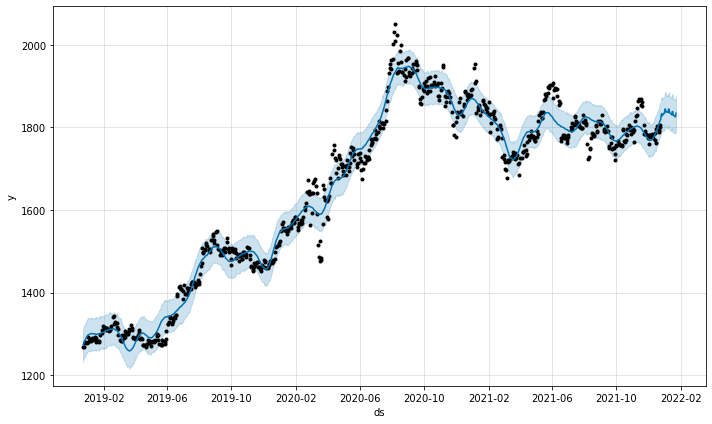

In [ ]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

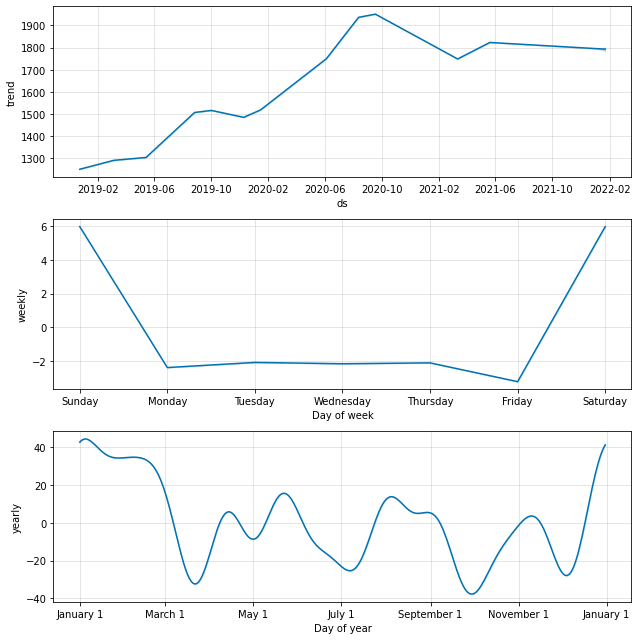

In [ ]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [ ]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ARIMA Model (Advanced)
This is an Autoregressive Integrated Moving Average Model

In [ ]:
!pip install pmdarima
import pmdarima as pm
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

     |████████████████████████████████| 1.4 MB 4.8 MB/s 
     |████████████████████████████████| 9.8 MB 37.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Data Preparation for ARIMA

In [ ]:
# Set stock ticker period to max 
arima_period = 'max'
arima_data = ticker.history(arima_period) # Same ticker as prophet model
print(stock)
arima_df=pd.DataFrame(arima_data,columns=['Close'])
arima_df.tail()

GC=F


,Close
Date,
2021-12-17,1803.800049
2021-12-20,1793.699951
2021-12-21,1787.900024
2021-12-22,1801.599976
2021-12-23,1806.699951


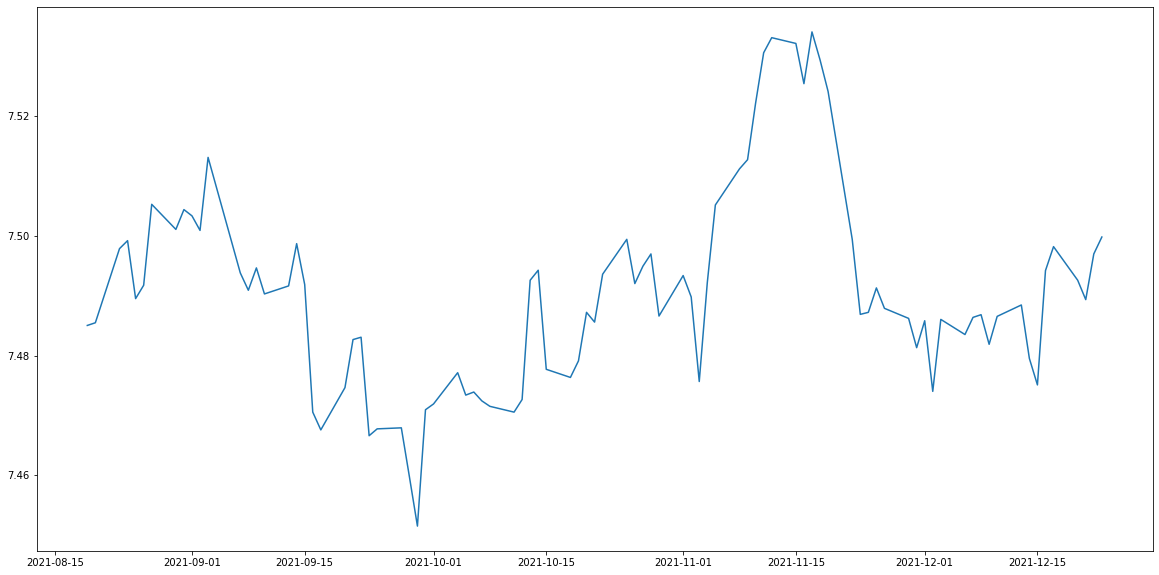

In [ ]:
#to reduce the difference in variance we will take log of data

arima_df['log_close'] = np.log1p(arima_df['Close'])
# zoom in on last 30 days
plt.figure(figsize=(20,10))
plt.plot(arima_df['log_close'][-90:])

In [ ]:
# Resample to Months
months_mean_close = arima_df['log_close'].resample('M').mean().to_frame()
months_mean_close.head()

,log_close
Date,
2000-08-31,5.624347
2000-09-30,5.614520
2000-10-31,5.601352
2000-11-30,5.586756
2000-12-31,5.607668


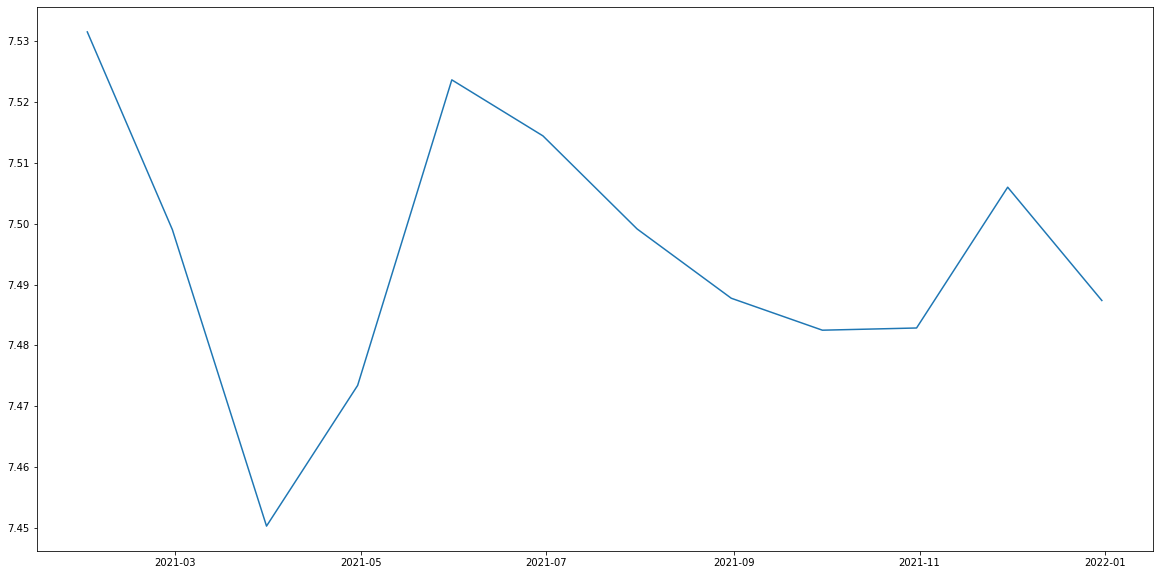

In [ ]:
# zoom in on last 12 months
plt.figure(figsize=(20,10))
plt.plot(months_mean_close[-12:])

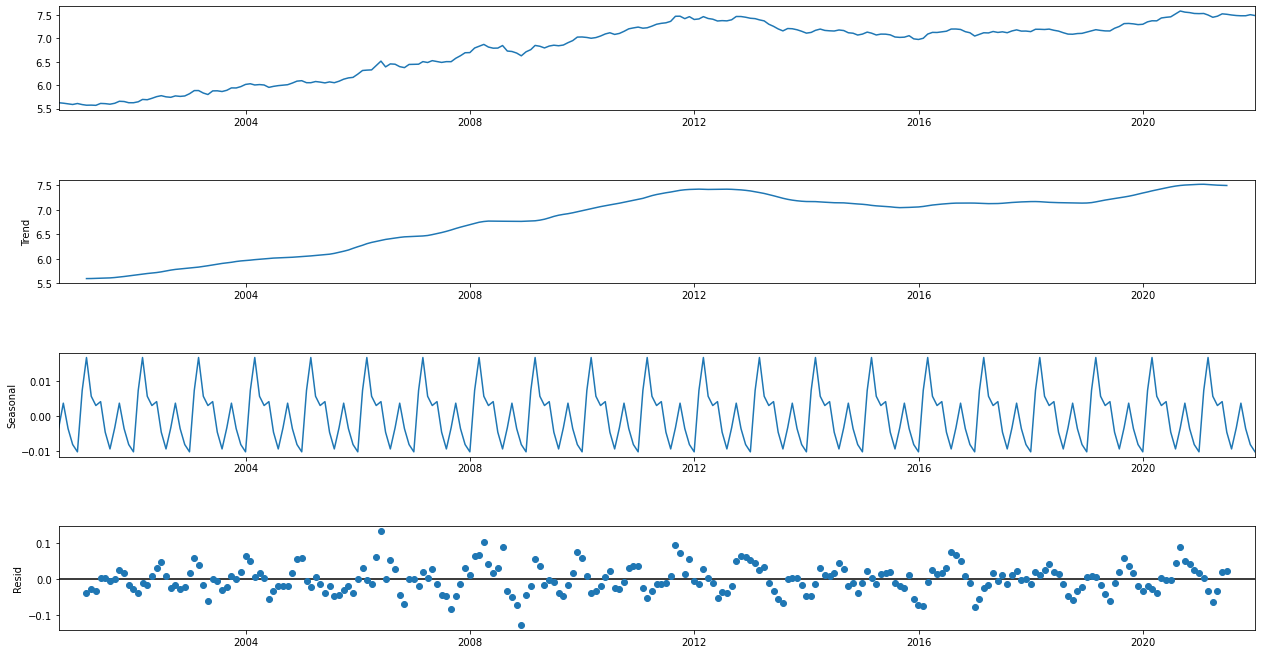

In [ ]:
# plot decomposition with 12 months frequency to capture seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
figure = seasonal_decompose(months_mean_close,period=12).plot()
figure.set_size_inches(20, 10)

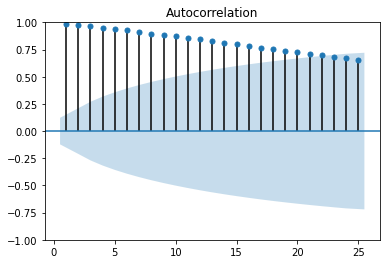

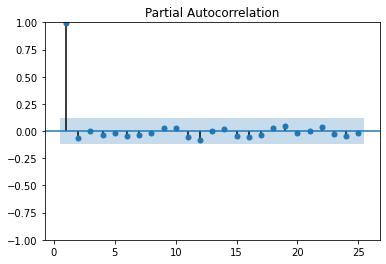

In [ ]:
sm.tsa.graphics.plot_acf(months_mean_close,zero=False)
sm.tsa.graphics.plot_pacf(months_mean_close,zero=False);

In [ ]:
months_mean_close['lag_12'] = months_mean_close.shift(12)
months_mean_close

,log_close,lag_12
Date,,
2000-08-31,5.624347,NaN
2000-09-30,5.614520,NaN
2000-10-31,5.601352,NaN
2000-11-30,5.586756,NaN
2000-12-31,5.607668,NaN
...,...,...
2021-08-31,7.487746,7.584192
2021-09-30,7.482500,7.560581
2021-10-31,7.482862,7.550234


In [ ]:
months_mean_close['year_diff'] = months_mean_close['log_close'] - months_mean_close['lag_12']
months_mean_close['year_diff'].dropna().to_frame()

,year_diff
Date,
2001-08-31,-0.011683
2001-09-30,0.040874
2001-10-31,0.048763
2001-11-30,0.037608
2001-12-31,0.016333
...,...
2021-08-31,-0.096446
2021-09-30,-0.078081
2021-10-31,-0.067372


In [ ]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -1.848311
p-value                   0.356754
Lags Used                12.000000
Observations Used       232.000000
Critical Value (1%)      -3.458855
Critical Value (5%)      -2.874080
Critical Value (10%)     -2.573453
dtype: float64


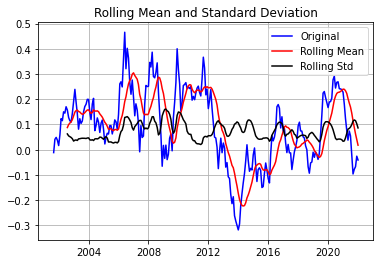

In [ ]:
# rund DF test, p-value more than 0.05 we fail to reject the null of non stationarity
dftest(months_mean_close['year_diff'].dropna())

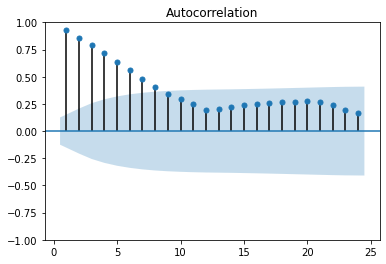

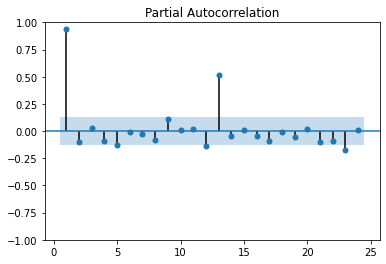

In [ ]:
sm.tsa.graphics.plot_acf(months_mean_close['year_diff'].dropna(),zero=False)
sm.tsa.graphics.plot_pacf(months_mean_close['year_diff'].dropna(),zero=False);

## Create ARIMA Model

In [ ]:
# Set Date Time Index to Daily Period
arima_df.index = pd.DatetimeIndex(arima_df.index).to_period('D')

In [ ]:
sar = sm.tsa.statespace.SARIMAX(arima_df.log_close, 
                                order=(0,0,0), 
                                seasonal_order=(0,1,0,7), 
                                trend='c').fit()

print(sar.summary())

                                SARIMAX Results                                
Dep. Variable:               log_close   No. Observations:                 5349
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood               11353.458
Date:                 Thu, 23 Dec 2021   AIC                         -22702.917
Time:                         16:01:49   BIC                         -22689.750
Sample:                     08-30-2000   HQIC                        -22698.317
                          - 12-23-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.000      6.153      0.000       0.002       0.003
sigma2         0.0008   1.06e-05     78.596      0.000       0.001       0.001
Ljung-Box (L1) (Q):                3854.17  

Run the diagnostics with no lag

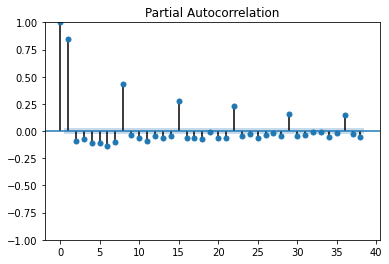

In [ ]:
sm.tsa.graphics.plot_pacf(sar.resid[sar.loglikelihood_burn:]);

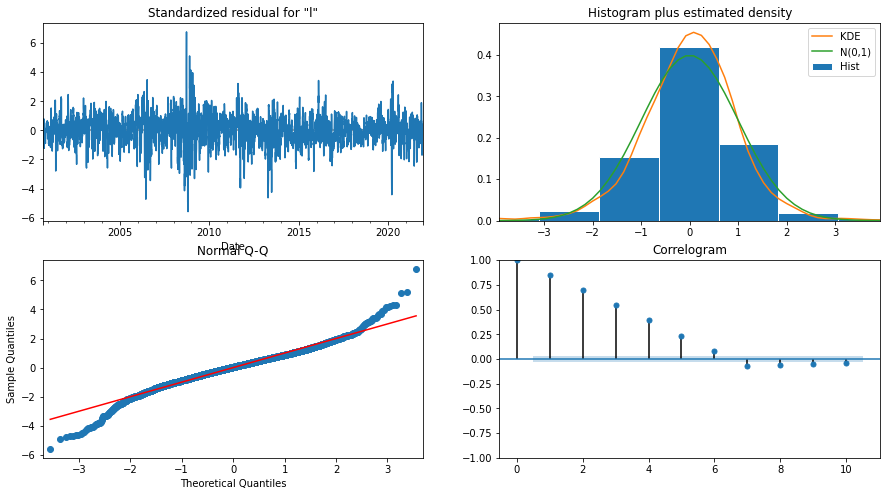

In [ ]:
sar.plot_diagnostics(figsize = (15,8));

Create an Auto Model to find the best Model with Seasonality (Weekly)

In [ ]:
auto_model = pm.auto_arima(arima_df.log_close, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=-22725.977, Time=12.53 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-22702.917, Time=1.88 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-30985.988, Time=20.84 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-26716.186, Time=11.84 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-22666.576, Time=0.39 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-29521.518, Time=1.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-31510.247, Time=31.75 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=-32559.463, Time=38.09 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=29.27 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=-32373.347, Time=43.90 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=52.09 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=-22722.000, Time=22.66 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=55.79 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=-32097.831, Time=41.73 sec
 ARIMA(0,0,1)(2

In [ ]:
print('order: ',auto_model.order)
print('seasonal order: ',auto_model.seasonal_order)

order:  (1, 0, 0)
seasonal order:  (2, 1, 1, 7)


In [ ]:
# Create second ARIMA model with the orders of the auto model
sar2 = sm.tsa.statespace.SARIMAX(arima_df.log_close, 
                                order=auto_model.order, 
                                seasonal_order=auto_model.seasonal_order, 
                                trend='c').fit()

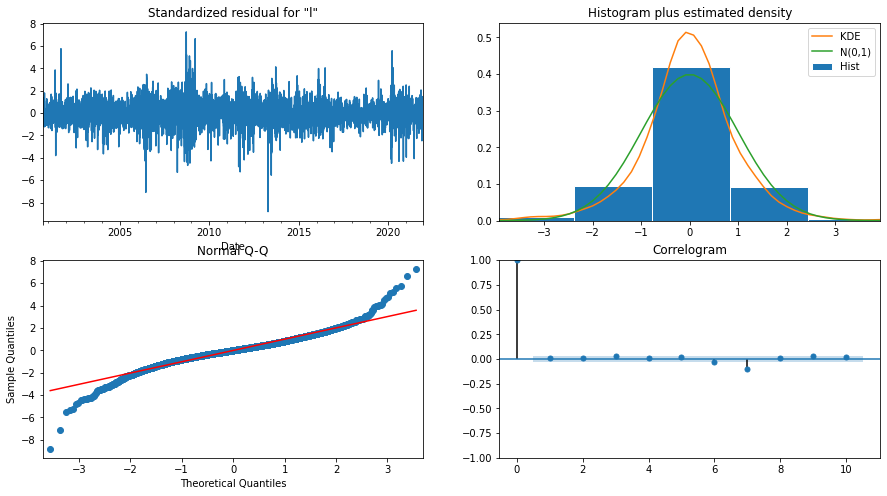

In [ ]:
sar2.plot_diagnostics(figsize = (15,8));

In [ ]:
# Helper function to cross validate
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (series): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [ ]:
warnings.filterwarnings("ignore")
series = arima_df.log_close
horizon = 7
start = int(len(arima_df.log_close)*.9)
step_size = 7
order = auto_model.order
seasonal_order = auto_model.seasonal_order

log_cv1 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [ ]:
# Exponent function to reverse the log
log_cv1 = np.expm1(log_cv1)

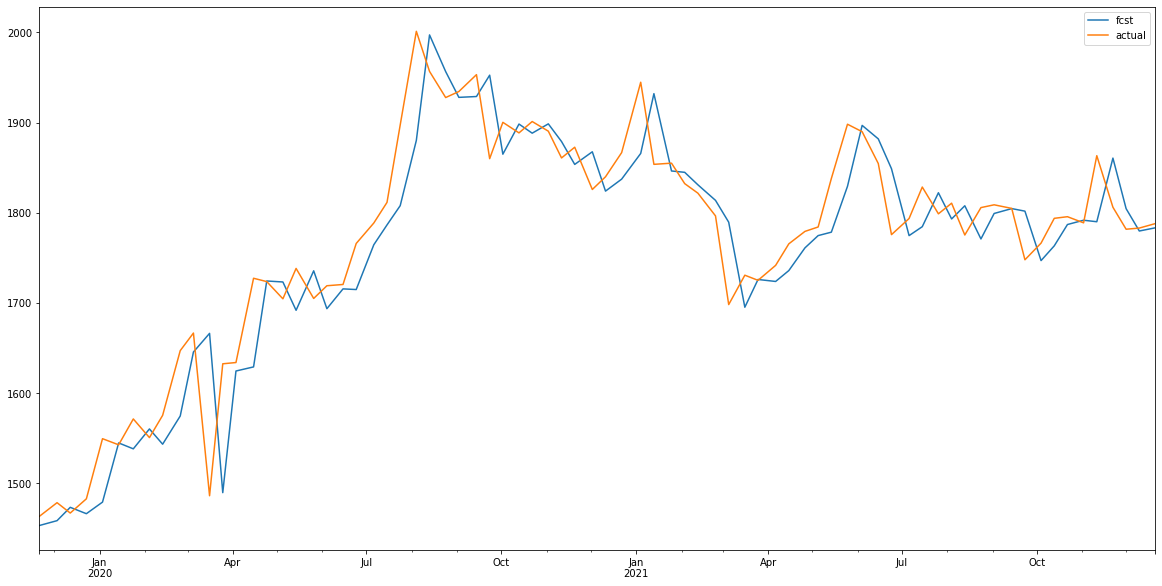

In [ ]:
log_cv1.plot(figsize=(20,10))

In [ ]:
#Defining an error metric to see out of sample accuracy (Mean absolute percentage error)
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [ ]:
# Calculate error metric
mape(log_cv1)

0.019672985868279688